In [114]:

from collections import defaultdict
import matplotlib


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [136]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [115]:
def plot_exon(locs,ax,h=0.25,offset = 0,bin_size=400,alpha=1,color="k",ecolor="k"):
  ax.add_patch(Rectangle((locs[0], -h + offset), locs[1] - locs[0], 2*h,edgecolor=ecolor,color=color,alpha=alpha,linewidth=0))

def load_gtf(gtf_file,filt_chr):
  gtf = pd.read_csv(gtf_file, names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"], sep="\t")
  if 'NC_000023.11' in gtf["seqname"].unique():
    can_chrom = [x for x in gtf["seqname"].unique() if x.startswith("NC_")]
    name_dict = {x : "chr" + str(int(x.split("_")[1].split(".")[0])) for x in can_chrom}
    name_dict['NC_000023.11'] = "chrX"
    name_dict['NC_000024.10'] = "chrY"
    name_dict['NC_012920.1'] = "chrM"
    gtf["seqname"] = gtf["seqname"].map(name_dict)
    gtf = gtf[~gtf["seqname"].isna()]
    filt_chr = False
  #   gtf = gtf[gtf["feature"] == "exon"]
  try:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_name").str[1].str.split(";").str[0].str.split('"').str[1]
  except:
    gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]
  gtf["transcript_id"] = gtf["attribute"].str.split("transcript_id").str[1].str.split(";").str[0].str.split('"').str[1]
#  filt_chr = True
  if filt_chr:
    # don't include immature scaffolds
    chromosomes = gtf["seqname"].unique()
    chromosomes = [x for x in chromosomes if "_" not in x and not x.startswith("KN")]
#    print("chromosomes",chromosomes)
    gtf = gtf[gtf["seqname"].isin(chromosomes)]
  gtf["chr_gene"] = gtf["seqname"] + gtf["gene_id"]
  return gtf


def annotation_plot(gtf, domains, gene, end, dataname, suff, rankLabel, outpath):
  rev_dict = {"Start" : "End","End" : "Start"}

  don_df = pd.read_csv("{}{}_{}_{}_{}_coords.tsv".format(outpath,rankLabel,dataname,gene,end),sep="\t")
  don_df = don_df.rename(columns={"rank_acc" : "rank", "rank_don" : "rank"}).astype(int)


  if don_df["juncStart"].nunique() == 1:
    let = "Start"
  else:
    let = "End"

  shared_ends = list(don_df["junc" + rev_dict[let]])

  zoom = True
  # for gene in genes:
  gene_gtf = gtf[gtf["gene_id"] == gene]
  gene_gtf = gene_gtf[gene_gtf["feature"].isin(["exon"])]

  if len(gene_gtf) == 0:
    return


  if don_df["junc" + rev_dict[let]].nunique() > 1:

    colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf',u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
    someX, someY = 0.5, 0.5
    plt.figure(figsize=(12, 6))
    h = 1
    offset = 1
    currentAxis = plt.gca()
    count = 1
    y_labels = []
    arc_height = 10
    y_ticks = []
    arcs = False
    print("++++++++")
    print(gene_gtf.head())
    print(gene_gtf.columns)
    chromosome = gene_gtf["seqname"].iloc[0]
    gene_min_all = gene_gtf["start"].min()
    gene_max_all = gene_gtf["end"].max()

    legend_elements = []

    gene_domains = domains[(domains[1] == chromosome) & (domains[2] < gene_max_all) & (domains[3] > gene_min_all)]

    # if arcs:
    # count = 1
    if gene_gtf["strand"].iloc[0] == "+":
      asc = True
    else:
      asc = False

    for ind, row in don_df.iterrows():
        plt.text(row["junc" + rev_dict[let]],gene_gtf["transcript_id"].nunique() + 1,row["rank"],horizontalalignment="center")
        plt.plot([row["junc" + rev_dict[let]],row["junc" + rev_dict[let]]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="red")
    plt.plot([row["junc" + let],row["junc" + let]],[ -0.5,gene_gtf["transcript_id"].nunique() + 0.5],color="blue")


    count = 0
    for transcript, trans_df in gene_gtf.groupby("transcript_id"):
      y_labels.append(transcript)
      y_ticks.append(count * offset)
      gene_min = trans_df["start"].min()
      gene_max = trans_df["end"].max()
      plt.plot([gene_min,gene_max],[offset * count,offset * count],color="k")

      for exons in set([tuple(x) for x in trans_df[["start","end"]].to_numpy()]):
        plot_exon(exons,currentAxis,offset = count * offset)
      i = 0
      for d in set([tuple(x) for x in gene_domains[[2,3,4]].to_numpy()]):
        plot_exon(d[:2],currentAxis,offset = count * offset,alpha = 0.4,color=colors[i],ecolor=None,h=0.5)
        legend_elements.append(Patch(facecolor=colors[i], edgecolor=None,label=d[2],alpha=0.4))
        i += 1

      count += 1

    if arcs:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + arc_height + 1])
    else:
      plt.ylim([-1,gene_gtf["transcript_id"].nunique() + 2])

    currentAxis.ticklabel_format(useOffset=False,style="plain")

    currentAxis.legend(handles=legend_elements[:gene_domains.shape[0]],bbox_to_anchor=(1., 1.0))
    plt.yticks(y_ticks,y_labels)
  #   plt.xlim([gene_min_all,gene_max_all])
    if zoom:
      print("end",end,"shared_ends",shared_ends)
      buff = max([abs(x - end) for x in shared_ends])/12
      plt.xlim(min([end] + shared_ends) - buff,max([end] + shared_ends) + buff)
    else:
      plt.xlim([gene_min_all,gene_max_all])

    plt.title("{} {} {} don".format(gene,chromosome,end))
    try:
      plt.savefig("{}{}_{}_{}_{}_don_ann{}.png".format(outpath,rankLabel,dataname,gene,end,suff),bbox_inches = "tight")
      plt.show()
    except Exception as e:
      print(e)

# create a color dictionary for donors (our colors)
def compartment_colors(compartments):
    compartment_color_dict = {comp : col for comp, col in zip(compartments,sns.color_palette("deep",len(compartments)))}
    return compartment_color_dict

def dot_plot(don_df, let, let_dict, palette, onts, gene, don, tiss, dataname, rev_dict, domains,gtf, alpha, suff, grouping_level_2, rankLabel, outpath):
  don_df["ontology_rank"] = don_df["ontology"] + don_df["rank_" + let_dict[let]].astype(str)
  don_df["rank_count"] = don_df["ontology_rank"].map(don_df.groupby("ontology_rank")["numReads"].sum())
  ont_dict = {o : i for o, i in zip(onts,range(1,don_df["ontology"].nunique() + 1))}
  don_df["ont_num"] = don_df["ontology"].map(ont_dict)
  pdf = don_df.drop_duplicates("ontology_rank")
  pdf["rank_sum"] = pdf["ontology"].map(pdf.groupby("ontology")["rank_count"].sum())
  pdf["frac_rank"] = pdf["rank_count"] / pdf["rank_sum"]
  print("ranks",pdf["rank_" + let_dict[let]].value_counts())
  pdf["rank_" + let_dict[let]] = pdf["rank_" + let_dict[let]].astype(int)

  ann_dict = pd.Series(pdf.splice_ann.values,index=pdf["rank_" + let_dict[let]]).to_dict()
  coords = pdf.drop_duplicates("rank_" + let_dict[let])[["rank_" + let_dict[let],"juncStart","juncEnd"]]
  coords = coords[coords["rank_" + let_dict[let]].isin(range(1,int(coords["rank_" + let_dict[let]].max() + 1)))].sort_values("rank_" + let_dict[let])
  end = int(coords["junc" + let].iloc[0])
  coords.to_csv("{}{}_{}_{}_{}_coords.tsv".format(outpath,rankLabel,dataname,gene,end),sep="\t",index=False)
  annotation_plot(gtf, domains, gene, end, dataname,suff, rankLabel, outpath)

  print("ann_dict",ann_dict)

  g = sns.relplot(x="rank_" + let_dict[let], y="ont_num", size="frac_rank",
              sizes=(10, 400), alpha=alpha, palette=palette,hue=grouping_level_2,
              height=max(4,pdf["ontology"].nunique()*0.3), data=pdf)
  for tick_label in g.ax.get_xticklabels():
    try:
      if float(tick_label.get_text()) in ann_dict.keys():
        if ann_dict[int(float(tick_label.get_text()))]:
          tick_label.set_color("blue")
        else:
          tick_label.set_color("red")
    except Exception as e:
      print(Exception)

  plt.yticks(range(1,don_df["ontology"].nunique() + 1),onts)
  plt.title("{}\n{} {} {} {}".format(dataname,gene,tiss, don, let_dict[rev_dict[let]]))
  plt.savefig("{}{}_{}_{}_{}_{}_{}_dot{}_dotplot.png".format(outpath,rankLabel, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff),bbox_inches="tight")
  plt.show()
  return 0
def plot_df(df, let, cell_lim, gene, dataname, let_dict, palette, rev_dict, don,tiss, don_df, comp_sort,suff,grouping_level_1,grouping_level_2,rankLabel, outpath):
#    df["num_cells"] = df["ontology"].map(df.groupby("ontology")["cell"].nunique())
#
#    df = df[df["num_cells"] > cell_lim]

    # calculate ontology-wide values to sort on
    df["ont_rank"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].median())
    df["ont_75"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.75))
    df["ont_25"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].quantile(0.25))

    df["ont_max"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].max())
    df["ont_min"] = df["ontology_" + let_dict[rev_dict[let]]].map(df.groupby("ontology_" + let_dict[rev_dict[let]])["avg_rank"].min())
    if comp_sort:
      df = df.sort_values(by=[grouping_level_1, grouping_level_2])
    else:
      df = df.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"])

    ann_dict = pd.Series(df.splice_ann.values,index=df["rank_" + let_dict[let]]).to_dict()

    num_cells = list(df.drop_duplicates("ontology")["num_cells"])
    medians = list(df.drop_duplicates("ontology")["ont_rank"])
    if df.shape[0] > 0:
      fig,(ax2) = plt.subplots(1)
      g = sns.boxplot(x="avg_rank", y="ontology",hue=grouping_level_2,dodge=False,
                       data=df,
                       orient="h", palette=palette)
#    for tick_label in g.ax.get_xticklabels():
    for i in range(len(ax2.get_xticklabels())):
      try:
        if ax2.get_xticks()[i] in ann_dict.keys():
          if ann_dict[int(float(tick_label.get_text()))]:
            ax2.get_xticklabels()[i].set_color("blue")
          else:
            ax2.get_xticklabels()[i].set_color("blue")
      except Exception as e:
        print(Exception)

#    for tick_label in ax2.get_xticks():

      try:
        if float(tick_label.get_text()) in ann_dict.keys():
          if ann_dict[int(float(tick_label.get_text()))]:
            tick_label.set_color("blue")
          else:
            tick_label.set_color("red")
      except Exception as e:
        print(Exception)

      for i,artist in enumerate(ax2.artists):
          # Set the linecolor on the artist to the facecolor, and set the facecolor to None
          col = artist.get_facecolor()
          artist.set_edgecolor(col)
          artist.set_facecolor('None')

          # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
          # Loop over them here, and use the same colour as above
          for j in range(i*6,i*6+6):
              line = ax2.lines[j]
              line.set_color(col)
              line.set_mfc(col)
              line.set_mec(col)
      # Also fix the legend
      for legpatch in ax2.get_legend().get_patches():
          col = legpatch.get_facecolor()
          legpatch.set_edgecolor(col)
          legpatch.set_linewidth(10)
          legpatch.set_facecolor('None')
#         medians = df.groupby("ontology")["avg_rank"].median()
      for i in range(len(num_cells)):
        plt.text(df["avg_rank"].max() + (df["avg_rank"].max() - df["avg_rank"].min())/12,i, num_cells[i])


        plt.scatter([medians[i]],[i],color = "k",s=20,zorder=100)
      plt.title("{}\n{} {} {} {}\nmean: {:0.2f} median: {:0.2f}".format(dataname,gene,tiss, don, let_dict[rev_dict[let]], don_df["avg_rank"].mean(), don_df["avg_rank"].median()))
      plt.legend(bbox_to_anchor=(1.5, 1.05))
      plt.savefig("{}{}_{}_{}_{}_{}_{}{}_boxplot.png".format(outpath,rankLabel, gene, don, tiss, dataname, let_dict[rev_dict[let]],suff),bbox_inches="tight")
      plt.show()
      return df
def box(
  df, let, cell_lim, gene, dataname, let_dict, palette, rev_dict, domains, gtf, alpha, comp_sort, suff, grouping_level_1, grouping_level_2, rankLabel, outpath):

  for don, don_df in df.groupby("pos{}_group".format(let)):
    temp = plot_df(
      don_df.drop_duplicates("pos{}_cell".format(let)),
      let,
      cell_lim,
      gene,
      dataname,
      let_dict,
      palette,
      rev_dict,
      don,
      "all",
      don_df,
      comp_sort,
      suff,
      grouping_level_1,
      grouping_level_2,
      rankLabel, outpath)
    if not temp is None:
      if temp["ontology"].nunique() > 0:
        onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())
        onts.reverse()
        response = dot_plot(don_df, let, let_dict, palette,onts, gene, don, "all", dataname, rev_dict,domains,gtf, alpha, suff, grouping_level_2, rankLabel, outpath)
    for tiss, tiss_df in don_df.groupby(grouping_level_1):
      temp = plot_df(
        tiss_df.drop_duplicates("pos{}_cell".format(let)),
        let,
        cell_lim,
        gene,
        dataname,
        let_dict,
        palette,
        rev_dict,
        don,
        tiss,
        don_df,
        comp_sort,
        suff,
        grouping_level_1,
        grouping_level_2,
        rankLabel, outpath)
      if not temp is None:
        if temp["ontology"].nunique() > 1:
          onts = list(temp.sort_values(["ont_rank","ont_75","ont_25","ont_max","ont_min"]).drop_duplicates("ontology")["ontology"].unique())
          onts.reverse()
          response = dot_plot(tiss_df, let, let_dict, palette,onts, gene, don, tiss, dataname, rev_dict, domains,gtf, alpha, suff, grouping_level_2, rankLabel, outpath)
          if type(response) != int:
            print("ERROR")
            return response

In [163]:
dataname = "V1_Mouse_Brain_Sagittal_Posterior"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior_Section_2"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
# dataname = "V1_Mouse_Kidney"
grouping_level_1 = "dummy"
grouping_level_2 = "quadrant"
# grouping_level_2 = "circle"
domain = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/SICILIAN_references/mouse/SICILIAN_mouse_mm10_Refs/domain_file/ucscGenePfam.txt"
svd = "/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium_2_June_2022/{}/SpliZ_values/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_0_r_0.01_light.pq".format(dataname,dataname)
meta = "/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/visium_meta/meta_{}.tsv".format(dataname)
gtf_file = "/oak/stanford/groups/horence/Roozbeh/single_cell_project/SICILIAN_references/mouse/SICILIAN_mouse_mm10_Refs/gtf_file/GCF_000001635.26_GRCm38.p6_genomic.gtf"
plotterFile = "/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium_2_June_2022/{}/SpliZ_sites/first_evec_{}_pvals_pixquant-dummy_100_S_0.1_z_0.0_b_0_r_0.01_light.tsv".format(dataname,dataname)
outpath = "/oak/stanford/groups/horence/JuliaO/visium_analysis/notebooks/output/boxplots/"


df = pd.read_parquet(svd)

if grouping_level_2 not in df.columns:
  meta = pd.read_csv(meta,sep="\t")
  df = df[[x for x in df.columns if x not in meta.columns]].merge(meta,left_on="cell",right_on="cell_id")

domains = pd.read_csv(domain, sep="\t", header=None)
gtf = load_gtf(gtf_file, True)

# only include ontology/gene pairs with at least 20 cells
cell_lim = 5
df["ontology"] = df[grouping_level_1].astype(str) + df[grouping_level_2].astype(str)
df["ontology_gene"] = df["ontology"] + df["gene"]
df["ontology_don"] = df["ontology"] + df["posA_group"]
df["ontology_acc"] = df["ontology"] + df["posB_group"]
df["num_cells"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())


df = df[df["num_cells"] > cell_lim]
df["num_cell_ont"] = df["ontology_gene"].map(df.groupby("ontology_gene")["cell"].nunique())
df = df[df["num_cell_ont"] > cell_lim]

pos_dict = {}
plotterFile = pd.read_csv(plotterFile, sep="\t")

  0%|          | 0/1 [00:00<?, ?it/s]

gene Gng13
1 (0, 107)
2 (0, 107)
3 (0, 108)
4 (0, 111)
gene size 2 (0, 112)
1 (3163, 107)
2 (3143, 107)
3 (3143, 108)
4 (3143, 111)
gene size 2 (3143, 112)
<class 'Exception'>


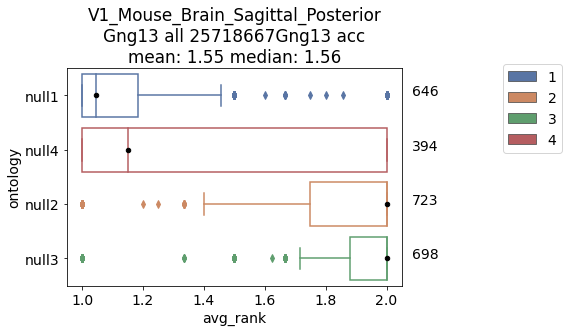

ranks 2.0    4
1.0    4
Name: rank_don, dtype: int64
++++++++
        seqname      source feature       start         end score strand  \
2310955   chr17  BestRefSeq    exon  25717172.0  25717277.0     .      +   
2310956   chr17  BestRefSeq    exon  25718667.0  25718798.0     .      +   
2310957   chr17  BestRefSeq    exon  25718927.0  25719102.0     .      +   
2310962   chr17  BestRefSeq    exon  25717528.0  25717581.0     .      +   
2310963   chr17  BestRefSeq    exon  25718667.0  25718798.0     .      +   

        frame                                          attribute gene_id  \
2310955     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310956     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310957     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310962     .  gene_id "Gng13"; transcript_id "NM_001357782.1...   Gng13   
2310963     .  gene_id "Gng13"; transcript_id "NM_001357782.1...   Gng13   

          transcript_id 

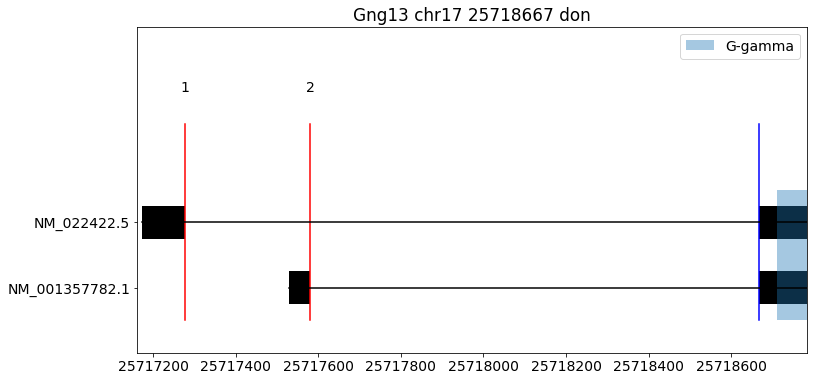

ann_dict {2: True, 1: True}


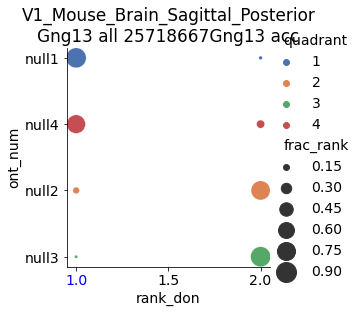

<class 'Exception'>


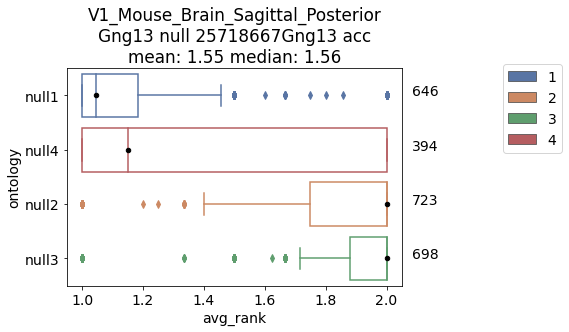

ranks 2.0    4
1.0    4
Name: rank_don, dtype: int64
++++++++
        seqname      source feature       start         end score strand  \
2310955   chr17  BestRefSeq    exon  25717172.0  25717277.0     .      +   
2310956   chr17  BestRefSeq    exon  25718667.0  25718798.0     .      +   
2310957   chr17  BestRefSeq    exon  25718927.0  25719102.0     .      +   
2310962   chr17  BestRefSeq    exon  25717528.0  25717581.0     .      +   
2310963   chr17  BestRefSeq    exon  25718667.0  25718798.0     .      +   

        frame                                          attribute gene_id  \
2310955     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310956     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310957     .  gene_id "Gng13"; transcript_id "NM_022422.5"; ...   Gng13   
2310962     .  gene_id "Gng13"; transcript_id "NM_001357782.1...   Gng13   
2310963     .  gene_id "Gng13"; transcript_id "NM_001357782.1...   Gng13   

          transcript_id 

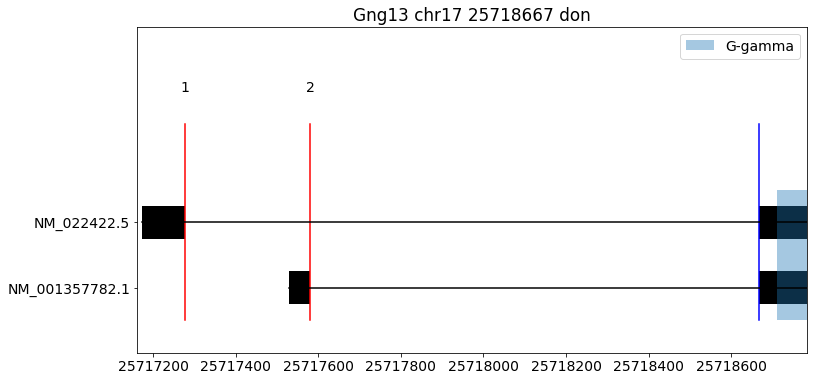

ann_dict {2: True, 1: True}


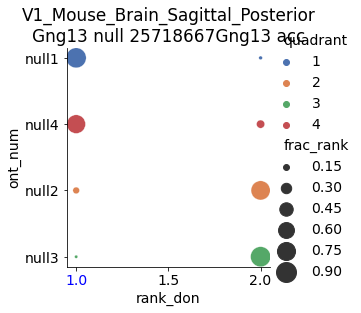

100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


In [164]:
pos_dict = {}
for gene, gene_df in df.groupby("gene"):
  pos_dict[gene] = list(gene_df["juncStart"].unique()) + list(gene_df["juncEnd"].unique())

pos_dict["Gng13"] = [25718667]
pos_dict["Myl6"] = [128491033.0]
pos_dict["Rps24"] = [24493493]
const_color = False
comp_sort = False

let_dict = {"Start" : "acc", "End" : "don"}
rev_dict = {"Start" : "End", "End" : "Start"}

exact = {}
exact["Gng13"] = ["juncStart",[25718667,25717581,25717277]]
exact["Myl6"] = ["juncEnd",list(df[df["gene"] == "Myl6"]["juncEnd"].value_counts().head(2).index)]
# exact["Rps24"] = ["juncStart",[24493493.0,24494069.0]]
# exact["Rps24"] = ["juncEnd",list(df[df["gene"] == "Rps24"]["juncEnd"].value_counts().head(5).index)]
exact["Rps24"] = ["juncEnd",[24493617,24495430,24495775.0]]
# exact["Rps24"] = ["juncEnd",[24493617,24495430]]
compartments = sorted([x for x in list(df[grouping_level_2].unique()) if x != None])
alpha = 1
if const_color:
  palette = defaultdict(lambda : "black")
else:
  palette = compartment_colors(compartments) #{"Endothelial" : u'#1f77b4', "Stromal" : u'#ff7f0e', "Epithelial" : u'#2ca02c', "Immune" : u'#d62728'}

# genes = list(pos_dict.keys())
genes = ["Gng13"]
# genes = ["Rps24"]
rank = 1

for gene in tqdm(genes):

    print("gene",gene)
    rankLabel = "rank_" + str(rank)


    for let in ["Start", "End"]:
#     for let in ["Start"]:
      gene_df = df[df["gene"] == gene]

      gene_df = gene_df[gene_df["junc{}".format(let)].isin(pos_dict[gene])]
      print("1",gene_df.shape)
      suff = ""
      if gene in exact.keys():
        gene_df = gene_df[gene_df[exact[gene][0]].isin(exact[gene][1])]
#         gene_df = gene_df[gene_df["free_annotation"].isin(exact[gene][2])]
        suff = "_exact"
      print("2",gene_df.shape)
      # find number of splice partners for each splice site
      gene_df["num_" + let_dict[let]] = gene_df["pos{}_group".format(let)].map(gene_df.groupby("pos{}_group".format(let))["pos{}_group".format(rev_dict[let])].nunique())
      temp = gene_df.copy()
      # only plot for those with more than one splice partner
#       gene_df = gene_df[gene_df["num_" + let_dict[let]] > 1]
      print("3",gene_df.shape)
      gene_df["pos{}_cell".format(let)] = gene_df["pos{}_group".format(let)] + gene_df["cell"]

      # rank each splice partner
      gene_df["rank_{}".format(let_dict[let])] = gene_df.groupby("pos{}_group".format(let))["junc{}".format(rev_dict[let])].rank(method="dense")

      # find sum of ranks of all reads for the cell
      gene_df["scaled_rank"] = gene_df["rank_" + let_dict[let]] * gene_df["numReads"]
      gene_df["num"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["scaled_rank"].sum())
      gene_df["denom"] = gene_df["pos{}_cell".format(let)].map(gene_df.groupby("pos{}_cell".format(let))["numReads"].sum())
      print("4",gene_df.shape)
      # calculate the average rank for the cell
      gene_df["avg_rank"] = gene_df["num"]/gene_df["denom"]
      print("gene size 2",gene_df.shape)

      box(gene_df, let, cell_lim, gene, dataname, let_dict, palette, rev_dict, domains, gtf, alpha, comp_sort, suff, grouping_level_1, grouping_level_2,rankLabel, outpath)

    rank += 1

